In [5]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [7]:
batch_size = 32  # This is the number of samples per gradient update.
time_steps = 100  # This is the 'window' of time steps you're looking at to predict the next step.
features = 2  # For univariate data, the number of features is 1.

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, stateful=True, batch_input_shape=(batch_size, time_steps, features)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True, stateful=True),
    Dropout(0.2),
    LSTM(50, activation='relu', stateful=True),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
def json_to_volumes(json):
    df = pd.read_json(json)
    volumes = df['total_volumes']
    prices = df['prices']
    coin_price = pd.DataFrame(prices.tolist(), columns=['time', 'prices'])
    coin_volume = pd.DataFrame(volumes.tolist(), columns=['time', 'total_volume'])
    # volumes = coin_volume['total_volume']
    merged_data = pd.merge(coin_price, coin_volume, on='time')
    
    return merged_data
    

# test = json_to_volumes('dai90days.json')
# test

In [9]:
def normalize_volumes(volumes):
    volumes['total_volume'] = (volumes['total_volume'] - np.mean(volumes['total_volume'])) / np.std(volumes['total_volume'])
    return volumes

In [10]:
def split_data(merged_data, split=0.8):
    train_size = int(len(merged_data) * split)
    test_size = len(merged_data) - train_size
    
    training_data = merged_data[0:train_size]
    test_data = merged_data[train_size:len(merged_data)]
    return training_data, test_data, train_size, test_size

    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [11]:
def create_dataset_helper(data, time_step=1):
    X, y = [], []
    data = data.reset_index(drop=True)

    for i in range(len(data) - time_step):      
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [12]:
def create_dataset(data, time_steps=1):
    X, y = create_dataset_helper(data, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y

In [13]:
def create_model():
    time_step = 10
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [14]:
def predictions(model, X_train, y_train, X_test, y_test, prices):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_predict = (train_predictions * np.std(prices)) + np.mean(prices)
    y_train = (y_train * np.std(prices)) + np.mean(prices)
    test_predict = (test_predictions * np.std(prices)) + np.mean(prices)
    y_test = (y_test * np.std(prices)) + np.mean(prices)
    
    train_score = sqrt(mean_squared_error(y_train, train_predict))
    print('Train Score: %.20f RMSE' % (train_score))
    test_score = sqrt(mean_squared_error(y_test, test_predict))
    print('Test Score: %.20f RMSE' % (test_score))
    return train_predict, test_predict

In [38]:
time_step = 10

merged_data = json_to_volumes('dai90days.json')
normalized_volumes = normalize_volumes(merged_data)
training_data, test_data, train_size, test_size = split_data(normalized_volumes)

X_train = normalized_volumes['total_volume'][0:train_size]
X_test = normalized_volumes['total_volume'][train_size:len(normalized_volumes)]
y_train = normalized_volumes['prices'][0:train_size]
y_test = normalized_volumes['prices'][train_size:len(normalized_volumes)]

merged_data

#X_train, y_train = create_dataset(training_data, time_step)
#X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
54/54 [==============================] - 5s 23ms/step - loss: 0.6986 - val_loss: 1.0266
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0985 - val_loss: 0.6565
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0188 - val_loss: 0.0901
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 5/100
54/54 [==============================] - 0s 5ms/step - loss: 1.5161e-05 - val_loss: 0.0054
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 9.6800e-06 - val_loss: 0.0042
Epoch 7/100
54/54 [==============================] - 0s 5ms/step - loss: 8.2449e-06 - val_loss: 0.0032
Epoch 8/100
54/54 [==============================] - 0s 5ms/step - loss: 6.9474e-06 - val_loss: 0.0024
Epoch 9/100
54/54 [==============================] - 0s 5ms/step - loss: 5.7798e-06 - val_loss: 0.0018
Epoch 10/100
54/54 [==============================] - 0s 5ms/step - loss: 4.8685e-06 - v

In [42]:
train_predict_dai, test_predict_dai = predictions(lstm, X_train, y_train, X_test, y_test, normalized_volumes['prices'])

train_predict_flattened_dai = train_predict_dai.flatten()
test_predict_flattened_dai = test_predict_dai.flatten()

train_predict_dai

14/14 [==============================] - 0s 3ms/step
Train Score: 0.00000182579926008921 RMSE
Test Score: 0.00001348903312131374 RMSE


array([[1.0007502],
       [1.0007502],
       [1.0007502],
       ...,
       [1.0007497],
       [1.0007497],
       [1.0007497]], dtype=float32)

# Graph

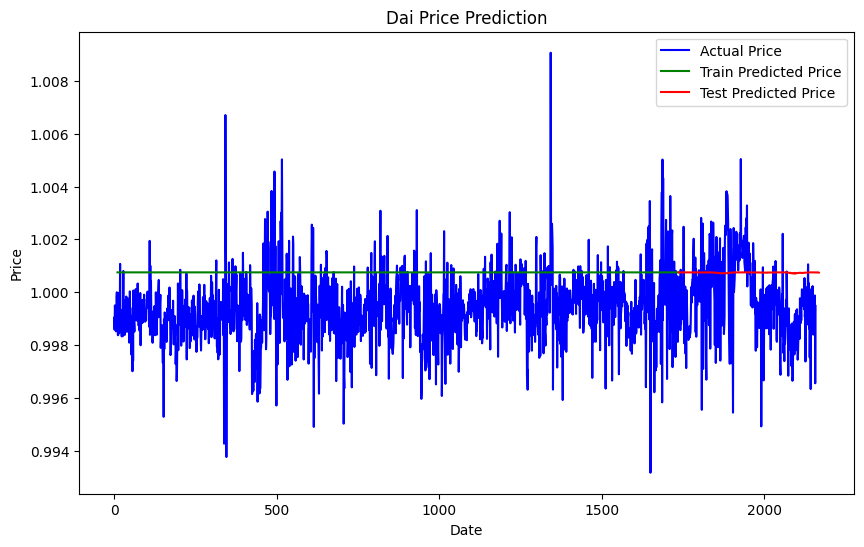

In [41]:
# graph the results of ethereum

# reshape train_predict and test_predict to the shape of prices

plt.figure(figsize=(10, 6))
plt.plot(merged_data['prices'], color='blue', label='Actual Price')
plt.plot(range(time_step, train_size + time_step), train_predict_flattened_dai, color='green', label='Train Predicted Price')
plt.plot(range(train_size + time_step, train_size + time_step + test_size), test_predict_flattened_dai, color='red', label='Test Predicted Price')

plt.title('Dai Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()